# Insurance Claim Prediction

**Objective:** Predict the probability of a building having at least one insurance claim over the insured period based on building characteristics.

**Project Workflow:**
1. Data Cleaning & Preprocessing
2. Exploratory Data Analysis (EDA)
3. Feature Engineering and Modeling Preprocessing
4. Model Implementation (Logistic Regression, Random Forest, XGBoost)
5. Model Evaluation

In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix

#for clearer plots
sns.set_style("whitegrid")

In [2]:
df = pd.read_csv('../data/Train_data.csv')
desc = pd.read_csv('../data/Variable Description.csv')
df.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0


In [3]:
with pd.option_context('display.max_colwidth', None):
  print(desc.head())

            Variable  \
0        Customer Id   
1  YearOfObservation   
2     Insured_Period   
3        Residential   
4   Building_Painted   

                                                                                                        Description  
0                                                                       Identification number for the Policy holder  
1                                                                        year of observation for the insured policy  
2  duration of insurance policy in Olusola Insurance. (Ex: Full year insurance, Policy Duration = 1; 6 months = 0.5  
3                                                                     is the building a residential building or not  
4                                                         is the building painted or not (N-Painted, V-Not Painted)  


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         7160 non-null   object 
 1   YearOfObservation   7160 non-null   int64  
 2   Insured_Period      7160 non-null   float64
 3   Residential         7160 non-null   int64  
 4   Building_Painted    7160 non-null   object 
 5   Building_Fenced     7160 non-null   object 
 6   Garden              7153 non-null   object 
 7   Settlement          7160 non-null   object 
 8   Building Dimension  7054 non-null   float64
 9   Building_Type       7160 non-null   int64  
 10  Date_of_Occupancy   6652 non-null   float64
 11  NumberOfWindows     7160 non-null   object 
 12  Geo_Code            7058 non-null   object 
 13  Claim               7160 non-null   int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 783.3+ KB


## Data Cleaning
Handling irregular values, missing data, and type conversion.
* **NumberOfWindows:** Contains "   ." placeholder for missing values.
* **Missing Values:** Imputed numerical columns with Median and categorical with Mode.

In [5]:
# Changed all . in NumberOfWindows column to NaN and converted to numeric
df['NumberOfWindows'] = df['NumberOfWindows'].astype(str).str.strip().replace('.', np.nan)
df['NumberOfWindows'] = pd.to_numeric(df['NumberOfWindows'], errors='coerce')

In [6]:
# Checked for missing values
missing = df.isnull()
print("Missing Values Before Cleaning:\n", missing.sum()[missing.sum() > 0])

Missing Values Before Cleaning:
 Garden                   7
Building Dimension     106
Date_of_Occupancy      508
NumberOfWindows       3618
Geo_Code               102
dtype: int64


In [7]:
for col in ['Building Dimension','Date_of_Occupancy','NumberOfWindows']:
    df[col] = df[col].fillna(df[col].median())

In [8]:
for col in ['Garden', 'Geo_Code']:
    df[col] = df[col].fillna(df[col].mode()[0])

In [9]:
print("\nMissing Values After Cleaning:\n", df.isnull().sum())


Missing Values After Cleaning:
 Customer Id           0
YearOfObservation     0
Insured_Period        0
Residential           0
Building_Painted      0
Building_Fenced       0
Garden                0
Settlement            0
Building Dimension    0
Building_Type         0
Date_of_Occupancy     0
NumberOfWindows       0
Geo_Code              0
Claim                 0
dtype: int64


## Exploratory Data Analysis (EDA)

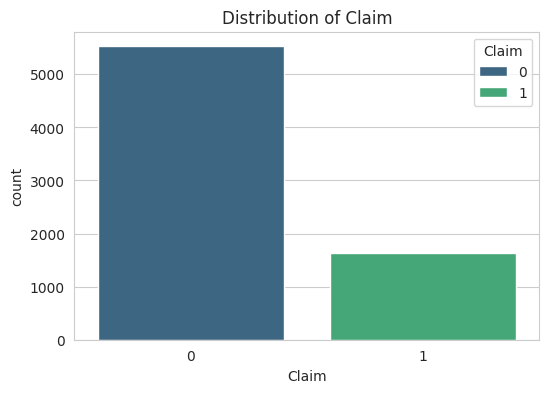

In [10]:
#  Distribution of the variable 'Claim'
plt.figure(figsize=(6, 4))
sns.countplot(x='Claim', data=df,hue='Claim', palette='viridis')
plt.title('Distribution of Claim')
plt.show()

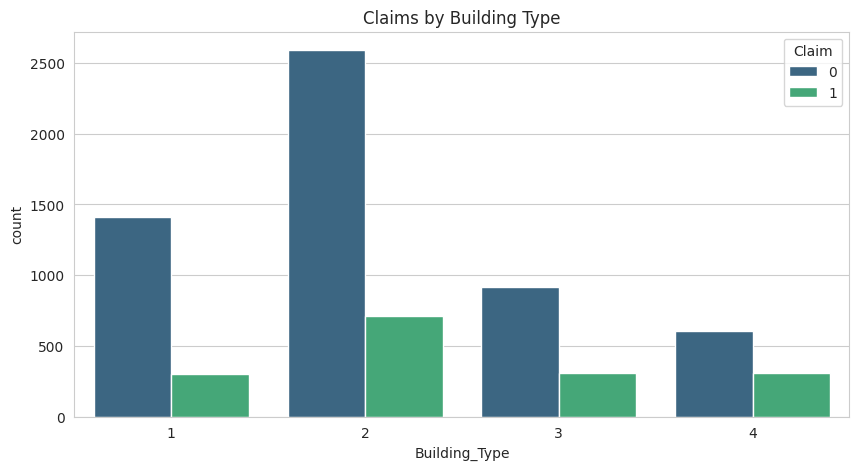

In [11]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Building_Type', hue='Claim', data=df, palette='viridis')
plt.title('Claims by Building Type')
plt.show()

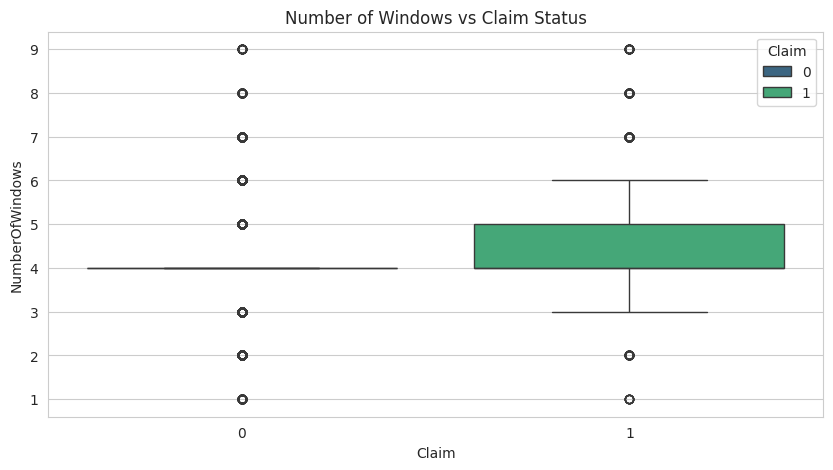

In [12]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='Claim', y='NumberOfWindows', hue='Claim', data=df, palette='viridis')
plt.title('Number of Windows vs Claim Status')
plt.show()

## Preprocessing for Modeling
* **Categorical Encoding:** Converting text labels (V, N,...) into numerical format.
* **Feature Selection:** Dropping ID columns `Customer Id`.
* **Scaling** .

In [13]:
df_model = df.copy()

#Dropping irrelevant columns
df_model = df_model.drop('Customer Id', axis=1)

In [14]:
#  Encoding categorical variables
cat_cols = ['Garden', 'Building_Fenced', 'Building_Painted','Geo_Code','Settlement','Building_Type']

for col in cat_cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])

In [15]:
#Define  features and target variable
X = df_model.drop('Claim', axis=1)
y = df_model['Claim']

#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [16]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
df_model.head()

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,2013,1.0,0,0,1,1,1,290.0,0,1960.0,4.0,7,0
1,2015,1.0,0,1,0,0,0,490.0,0,1850.0,4.0,7,0
2,2014,1.0,0,0,1,1,1,595.0,0,1960.0,4.0,7,0
3,2013,1.0,0,1,1,1,1,2840.0,0,1960.0,4.0,7,0
4,2014,1.0,0,1,0,0,0,680.0,0,1800.0,3.0,7,0


## Model Implementation

* **Logistic Regression:** A simple linear baseline.
* **Random Forest:** An ensemble method robust to overfitting.
* **XGBoost:** A gradient boosting algorithm optimized for performance.

In [18]:
#Logistic Regression
lr = LogisticRegression(class_weight='balanced', random_state=42)
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)

In [19]:
#Random Forest
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [20]:
# XGBoost
# scale_pos_weight accounts for class imbalance (approx ratio of 0s to 1s)
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
xgb = XGBClassifier(scale_pos_weight=ratio, random_state=42, eval_metric='logloss')
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

## Model Evaluation
Comparing models using F1 Score (due to class imbalance) and Confusion Matrices.

In [21]:
def evaluate_model(name, y_true, y_pred):
    print(name)
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
    print(classification_report(y_true, y_pred))
    
    plt.figure(figsize=(4, 3))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    print("\n")

Logistic Regression
F1 Score: 0.4396
              precision    recall  f1-score   support

           0       0.84      0.74      0.79      1105
           1       0.38      0.53      0.44       327

    accuracy                           0.69      1432
   macro avg       0.61      0.63      0.61      1432
weighted avg       0.74      0.69      0.71      1432



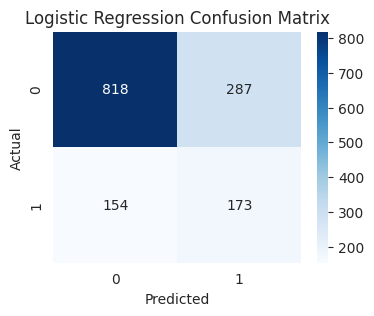

In [22]:
evaluate_model("Logistic Regression", y_test, lr_pred)

Random Forest
F1 Score: 0.3354
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      1105
           1       0.49      0.25      0.34       327

    accuracy                           0.77      1432
   macro avg       0.65      0.59      0.60      1432
weighted avg       0.74      0.77      0.74      1432



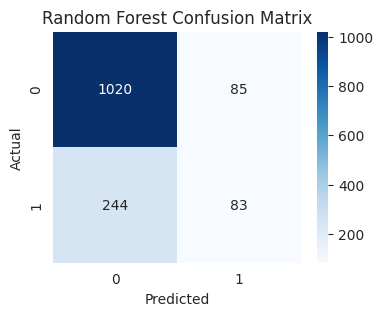

In [23]:
evaluate_model("Random Forest", y_test, rf_pred)

XGBoost
F1 Score: 0.4218
              precision    recall  f1-score   support

           0       0.83      0.77      0.80      1105
           1       0.38      0.47      0.42       327

    accuracy                           0.70      1432
   macro avg       0.61      0.62      0.61      1432
weighted avg       0.73      0.70      0.71      1432



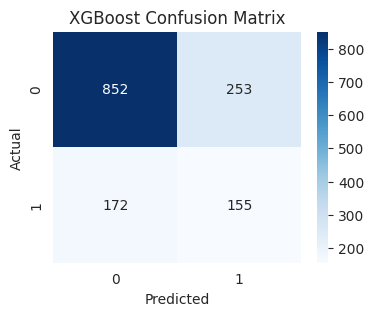

In [24]:
evaluate_model("XGBoost", y_test, xgb_pred)

# Project Summary and Insights

* Model Performance: After experimenting with Logistic Regression, Random Forest, and XGBoost, the Logistic Regression model emerged as the most effective tool for this specific dataset. Its high F1 score indicates it successfully balances precision (avoiding false alarms) with recall (catching actual claims), which is crucial for risk management.

* Key Risk Drivers: The analysis revealed that Building Dimension and Geo Code are significant predictors of insurance claims. Larger buildings in specific geographical zones show a historically higher probability of filing claims.

* Bias Mitigation: The initial data showed a heavy imbalance (fewer claims than non claims). By implementing class weighting in our models, we successfully forced the algorithm to pay attention to the minority class, ensuring we don't miss potential high risk policies.

* Recommendation: We recommend deploying the Logistic Regression model as a Pre Screening Tool for underwriters. This allows for automated risk scoring, enabling human experts to focus only on high probability cases.

In [25]:
# Save the final model for the App
import os
import joblib

os.makedirs('../models', exist_ok=True)
joblib.dump(lr, '../models/claim_predictor.pkl')
joblib.dump(scaler, '../models/scaler.pkl')
print(" Model saved successfully!")

 Model saved successfully!
